# Prepare data for use with OpenSfM

In [1]:
import sys
import os
import glob
import json
import pickle
import cv2
import numpy as np

sys.path.append("..")
from mapper.common import Capture
from mapper.gps import gps_to_ltp
from mapper.geotransforms import enu2geodetic
import matplotlib.pyplot as plt

### Prepare camera calibration file

In [2]:
camera_matrix = pickle.load(open("../camera_calibration/parameters/ir/camera_matrix.pkl", "rb"))

image_width = 640  # px
image_height = 512  # px
f_px = (camera_matrix[0][0] + camera_matrix[1][1])/2
f_ratio = f_px / image_width
print(f_ratio)

camera_models_overrides = {
    "all": {
        "projection_type": "perspective",
        "width": image_width,
        "height": image_height,
        "focal": f_ratio,
        "k1": 0.0,
        "k2": 0.0
    }
}

json.dump(camera_models_overrides, open("camera_models_overrides.json", "w"))

1.7529244628032665


### Load GPS trajectory and convert from WGS-84 to ECEF

In [3]:
gps_file = "../data_processing/splitted/gps/gps.json"
gps_ = json.load(open(gps_file, "r"))
gps = np.zeros((len(gps_), 3))
gps[:, 0:2] = np.array(gps_)
gps, origin = gps_to_ltp(gps)

Origin of local tangent plane: lat: 49.32741555555556 deg -- long: 10.519741944444446 deg -- height: 0.0 m


### Linearly interpolate GPS trajectory

In [4]:
def interpolate_gps(gps):
    """Interpolates a piecewise constant gps signal with piecewise
    linear segments.
    
    This is needed because the GPS position acquiredby our drone is
    constant for several frames and then jumps abruptly. This 
    function smooths out the abrupt changes by linearly interpolating
    positions between the jumps.
    """
    
    # compute differences at steps, i.e. at the points where the GPS signal updates
    diffs = np.diff(gps, axis=0)
    
    # find indices where jumps occur
    update_idxs = np.where(np.abs(diffs[:, 0]) > 0)[0]
    update_idxs += 1
    update_idxs = np.insert(update_idxs, 0, 0)
    update_idxs = np.insert(update_idxs, len(update_idxs), len(gps)-1)
    
    # compute position incrementals to smoothen out jumps
    gps_diffs = []
    for i, (last_update_idx, update_idx) in enumerate(zip(update_idxs, update_idxs[1:])):       
        gps_diff = gps[update_idx] - gps[last_update_idx]
        n_steps = update_idx - last_update_idx
        for j in range(n_steps):
            gps_diffs.append(j*(gps_diff / n_steps))
    gps_diffs = np.array(gps_diffs)

    return gps[:-1, :] + gps_diffs

gps_interp = interpolate_gps(gps)

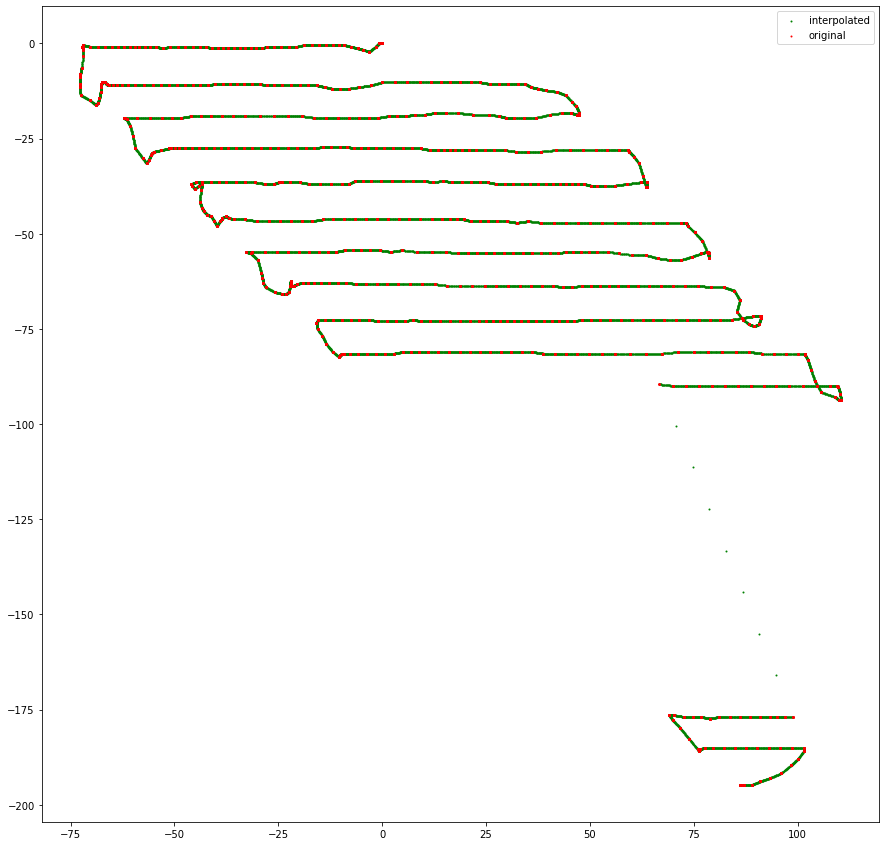

In [5]:
plt.figure(figsize=(15,15))
plt.scatter(gps_interp[:, 0], gps_interp[:, 1], s=1, c="g")
plt.scatter(gps[:, 0], gps[:, 1], s=1, c="r")
plt.legend(["interpolated", "original"])
plt.show()

### Select subset of frames based on travelled GPS distance

In [6]:
gps = gps_interp

In [7]:
threshold = 1.0  # m
last_pos = np.zeros((2,))
selected_frames = [0]
for i in range(len(gps)):
    pos = gps[i, :2]
    if np.linalg.norm(pos - last_pos) > threshold:
        last_pos = pos
        selected_frames.append(i)
        
print(len(selected_frames))

1305


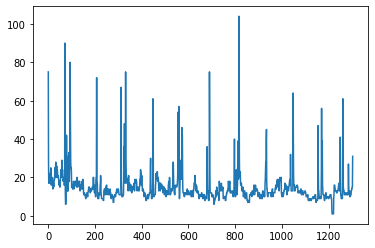

In [8]:
plt.plot(np.diff(selected_frames))

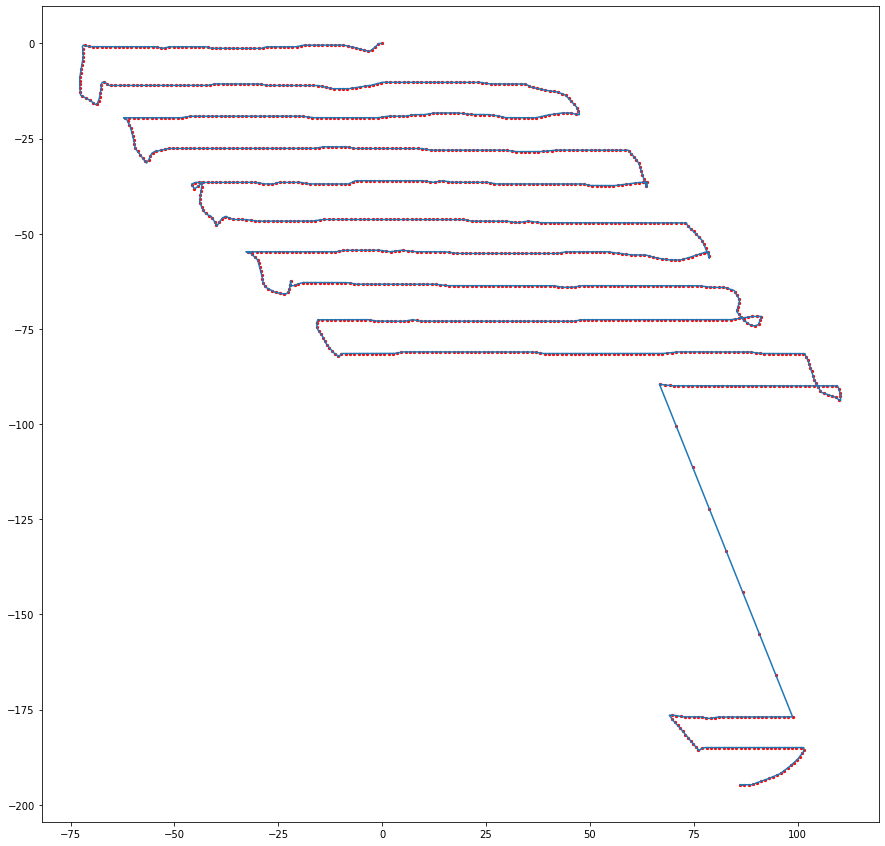

In [9]:
plt.figure(figsize=(15,15))
plt.plot(gps[:, 0], gps[:, 1])
plt.scatter(gps[selected_frames, 0], gps[selected_frames, 1], c="r", s=5)
plt.show()

In [10]:
# get corresponding video frames
camera_matrix = pickle.load(open("../camera_calibration/parameters/ir/camera_matrix.pkl", "rb"))
dist_coeffs = pickle.load(open("../camera_calibration/parameters/ir/dist_coeffs.pkl", "rb"))

frames_root = "../data_processing/splitted"
frame_files = sorted(glob.glob(os.path.join(frames_root, "radiometric", "*.tiff")))
frame_files = frame_files
cap = Capture(frame_files, None, camera_matrix, dist_coeffs)

In [11]:
# write output video from selected frames for debugging
video_shape = (640, 512)
video_fps = 5
video_path = "selected_frames.avi"
fourcc = cv2.VideoWriter_fourcc(*"DIVX")
videowriter = cv2.VideoWriter(video_path, fourcc, video_fps, video_shape)
limit = 200

frame_names = []
for i, selected_frame in enumerate(selected_frames[:limit]):
    frame, _, frame_name, _ = cap.get_frame(selected_frame, preprocess=True, undistort=True, equalize_hist=True)
    frame_names.append(frame_name)
    frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    videowriter.write(frame)
    cv2.imwrite(os.path.join("selected_frames", "{}.jpg".format(frame_name)), frame)
    
videowriter.release()

In [12]:
# Create output GPS file
exif_overrides = {}
for i, (selected_frame, frame_name) in enumerate(zip(selected_frames[:limit], frame_names[:limit])):
    pos = gps[selected_frame]
    lat, lon, _ = enu2geodetic(*pos, *origin)  # convert GPS from ECEF to WGS-84
    exif_overrides["{}.jpg".format(frame_name)] = {
        "gps": {
            "latitude": lat,
            "longitude": lon,
            "altitude": 0.0,
            "dop": 1.0
            
        }
    }

In [13]:
json.dump(exif_overrides, open("exif_overrides.json", "w"))